# Project 2 – Weather and NYC Yellow Taxi Demand

## Introduction

In this project, I move beyond a single dataset and look at how two different data sources can work together to tell a story about New York City. Instead of focusing only on how people use yellow taxis, I ask how those choices might shift with something everyone feels but rarely measures carefully in their daily lives: the weather.

I approach this project with a few guiding questions:

1. How does daily weather – especially temperature and rain – relate to how often New Yorkers take yellow taxis?
2. Are there clear patterns, such as colder or rainy days pushing more people into cabs, or is the relationship weak and noisy?
3. When we put official taxi data and weather observations side by side, does the pattern match what we intuitively expect from living in a big city?

To explore these questions, I combine two real-world datasets. The first is the official 2019 yellow taxi trip records from NYC Open Data. The second is a Kaggle weather dataset that reports daily conditions in New York City over the same period, including temperature and precipitation.

Because the full year of yellow taxi data contains tens of millions of rows and produces very large files, I restrict my analysis to trips that occurred in January 2019. This monthly slice is small enough to process comfortably in pandas while still providing a meaningful range of weather conditions and everyday travel patterns. Throughout the notebook, I treat January as a focused case study rather than an attempt to describe the entire year.

My goal is to aggregate both datasets to the daily level and then use pandas to merge them into a single table that tracks, for each day, how many yellow taxi trips occurred and what the weather was like. With this combined view, I create visualizations that place daily trip counts and average temperature on the same timeline and compare rainy versus non-rainy days. Finally, I compute a simple correlation and reflect on whether the data support the common intuition that bad weather makes people more likely to hail a cab, or whether the story is more complicated than that.

## Source Dataset

2019 Yellow Taxi Trip Data — NYC Open Data  

https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp/about_data

New York City Weather Data (2019)

https://www.kaggle.com/datasets/rohiteng/new-york-city-weather-data-2019


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

TAXI_PATH = "yellow_taxi_201901.csv"
WEATHER_PATH = "nyc_weather.csv"


## Taxi Data: From Raw Trips to Daily Counts

I start by loading the yellow taxi trip data that I exported from NYC Open Data.  
This file contains one row per trip, with pickup and dropoff timestamps for each ride.

Because I am interested in how overall demand changes day by day, I do not need
all of the original columns. I keep only the pickup and dropoff times and then
use the pickup timestamp to compute how many trips happened on each day.

The CSV I exported already focuses on trips between January 1–7, 2019, so the
daily counts below cover just this one-week slice.


In [ ]:
use_cols = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
]

taxi = pd.read_csv(
    TAXI_PATH,
    usecols=use_cols,
    parse_dates=["tpep_pickup_datetime"],
)

taxi["date"] = taxi["tpep_pickup_datetime"].dt.date

taxi_daily = (
    taxi.groupby("date")
    .size()
    .reset_index(name="trip_count")
    .sort_values("date")
    .reset_index(drop=True)
)

print("Taxi daily shape:", taxi_daily.shape)
taxi_daily.head()

/var/folders/gz/3xjyxwqx3zd0nrs8j35d5j0m0000gn/T/ipykernel_37800/4166852095.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Taxi daily shape: (7, 2)


,date,trip_count
0,2019-01-01,189034
1,2019-01-02,197852
2,2019-01-03,222878
3,2019-01-04,235053
4,2019-01-05,236040


## Weather Data: Daily Temperature and Precipitation

Next, I load the NYC weather dataset from Kaggle.  
Each row in this file already represents one calendar day, with columns for
the average temperature (`tavg`) and daily precipitation, among other variables.

To match the taxi data, I restrict the weather data to the exact same one-week
period (2019-01-01 to 2019-01-07) and keep only three fields:

- `date` – the calendar date  
- `temp_C` – the average temperature in °C  
- `precip_mm` – total daily precipitation in millimeters

This produces a simple daily table that can be merged with the taxi counts.


In [ ]:
import datetime as dt
import pandas as pd

weather = pd.read_csv(WEATHER_PATH)

weather["date_value"] = pd.to_datetime(weather["date_value"])

mask = (weather["date_value"] >= dt.datetime(2019, 1, 1)) & (
    weather["date_value"] <= dt.datetime(2019, 1, 7)
)
weather_7 = weather.loc[mask].copy()

weather_7["date"] = weather_7["date_value"].dt.date

weather_daily = (
    weather_7[["date", "tavg", "precipitation"]]
    .rename(
        columns={
            "tavg": "temp_C",
            "precipitation": "precip_mm",
        }
    )
    .sort_values("date")
    .reset_index(drop=True)
)

print(weather_daily.shape)
weather_daily

(7, 3)


,date,temp_C,precip_mm
0,2019-01-01,8.38,3.57
1,2019-01-02,14.41,2.87
2,2019-01-03,9.78,4.89
3,2019-01-04,5.55,1.14
4,2019-01-05,13.96,4.70
5,2019-01-06,11.22,2.36
6,2019-01-07,4.60,0.16


## Combining the Two Datasets

With daily aggregates prepared for both sources, I can now merge them on the
`date` column. This produces a single table where each row represents one day
and includes:

- the total number of yellow taxi trips (`trip_count`)
- the average temperature (`temp_C`)
- the amount of precipitation (`precip_mm`)

This merged table is the basis for my visualization and small numerical checks.


In [8]:
merged = pd.merge(taxi_daily, weather_daily, on="date", how="inner")
merged.sort_values("date", inplace=True)
merged.reset_index(drop=True, inplace=True)

merged

,date,trip_count,temp_C,precip_mm
0,2019-01-01,189034,8.38,3.57
1,2019-01-02,197852,14.41,2.87
2,2019-01-03,222878,9.78,4.89
3,2019-01-04,235053,5.55,1.14
4,2019-01-05,236040,13.96,4.70
5,2019-01-06,208193,11.22,2.36
6,2019-01-07,224839,4.60,0.16


## Visualization: Daily Taxi Trips vs Average Temperature

To see how taxi demand and weather move together over this week, I plot both
series on the same chart:

- the left y-axis shows daily yellow taxi trip counts  
- the right y-axis shows the daily average temperature in °C  

Placing the two lines on a shared time axis makes it easier to visually inspect
whether colder or warmer days line up with higher or lower taxi usage.


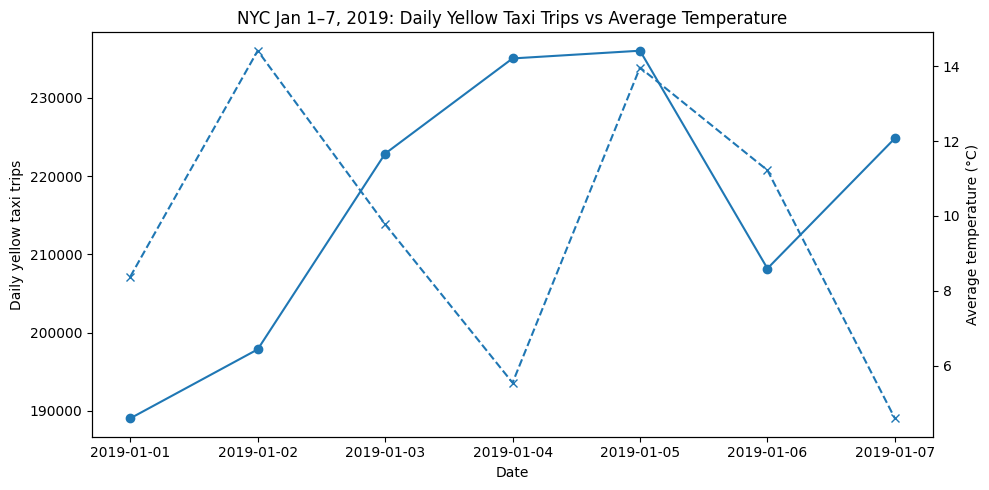

In [11]:
fig, ax1 = plt.subplots()

ax1.plot(merged["date"], merged["trip_count"], marker="o")
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily yellow taxi trips")

ax2 = ax1.twinx()
ax2.plot(merged["date"], merged["temp_C"], marker="x", linestyle="--")
ax2.set_ylabel("Average temperature (°C)")

plt.title("NYC Jan 1–7, 2019: Daily Yellow Taxi Trips vs Average Temperature")
plt.tight_layout()
plt.show()


## A Simple Correlation Check

The line chart gives a visual sense of how temperature and taxi demand move
together, but it can be hard to tell how strong that relationship really is
just by looking.

To get a quick numerical summary, I compute the Pearson correlation between
daily average temperature (`temp_C`) and daily yellow taxi trip counts
(`trip_count`) over this one-week period. This produces a single number between
-1 and 1:

- values near **1** indicate a strong positive linear relationship  
- values near **-1** indicate a strong negative linear relationship  
- values near **0** indicate little or no linear relationship  

With only seven days of data, this is more of a descriptive check than a
formal statistical conclusion, but it still helps quantify what we see in
the plot.


In [12]:
corr_temp_trip = merged["temp_C"].corr(merged["trip_count"])
corr_temp_trip

np.float64(-0.23840463734628198)

## What do the plot and correlation tell us?

Putting the line chart and the correlation together, the relationship between
weather and yellow taxi demand in this week looks quite weak.

From the plot, daily trip counts stay in a fairly narrow band between roughly
190,000 and 235,000 rides per day. The temperature moves up and down across
the week, but the peaks and dips in temperature do not line up cleanly with
peaks and dips in taxi demand. For example, some of the warmer days do not
clearly correspond to noticeably higher or lower trip counts.

Numerically, the Pearson correlation between daily average temperature and
daily trip counts is about **-0.24**. This small negative value means that,
over these seven days, colder days tend to have *slightly* higher taxi demand
and warmer days tend to have *slightly* lower demand — but the effect is weak.
Many other factors (such as day of week, holidays, and commuting patterns) are
likely driving most of the variation we see.

Because we only have seven data points and are looking at a single week in
January, I interpret this correlation as a descriptive summary rather than a
strong conclusion. The main takeaway is that, in this short window, weather
does not appear to be a dominant driver of yellow taxi usage, even though it
may play a small role on the margins.


## Takeaways

Working on this project taught me a lot about what it actually takes to move
from “two CSV files” to a coherent story. The taxi dataset was large and
initially overwhelming, and I quickly ran into practical issues such as file
size limits on GitHub and slow loading times in my notebook. This pushed me to
make deliberate choices: exporting only the columns I needed, focusing on a
one-week slice (Jan 1–7, 2019), and using groupby operations to collapse
millions of individual trips into a simple daily summary. I also had to pay
attention to details I used to overlook, such as specifying the correct datetime
format so that pandas could parse the pickup times reliably.

Merging the taxi data with the weather dataset was another useful learning
experience. Even though both files had dates, they did not line up perfectly
at first, and I had to standardize the date representation and carefully select
matching ranges. Once the merge worked, I could see how two independent public
datasets—one from NYC Open Data and one from Kaggle—could be combined to
answer a real question. This felt very different from working with a single,
clean classroom dataset.

Finally, I realized how important it is to think critically about what the data
*cannot* tell me. With only seven days of observations, any numerical result
has to be interpreted cautiously, and many factors that affect taxi demand are
not in my tables at all. Instead of treating the analysis as a definitive
answer, I now see it as a small case study and a prototype workflow: cleaning,
aggregating, merging, visualizing, and reflecting on limitations. This process
gave me more confidence in using pandas and matplotlib, and also made me more
aware of the gap between raw data and meaningful, honest conclusions.

